<a href="https://colab.research.google.com/github/jovitaand/Default-of-Credit-Card-Analysis/blob/main/Default_Of_Credit_Card_Clients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  # Default of Credit Card Clients - Predictive Models
  This study examines the predictive accuracy of six data mining methods for estimating the probability of customer default in Taiwan. Unlike binary classification (credible or not credible), the focus is on estimating the real probability of default, which provides more valuable insights for risk management. A novel Sorting Smoothing Method was introduced to estimate the real probability of default, using it as the response variable (Y) in a simple linear regression model against the predicted probability (X). Results show that the Artificial Neural Network (ANN) model outperforms other methods, achieving the highest coefficient of determination. Its regression intercept (A) is near zero, and regression coefficient (B) is close to one, indicating that ANN is the most accurate model for estimating the real probability of default.

  # Quantitative Analysis of a Societally Relevant Dataset

## Goal
Explore a dataset with societal relevance to build and evaluate a predictive model while addressing ethical concerns such as bias, fairness, and interpretability.

## Dataset
Choose a dataset relevant to societal issues, such as the UCI Adult Dataset.

---

## Key Steps

### 1. Data Preprocessing and Cleaning
- Handle missing values appropriately.
- Group underrepresented categories to improve data representation and robustness.

### 2. Model Training and Evaluation
- Train a predictive model, such as a decision tree, random forest, or neural network.
- Evaluate performance using metrics like **balanced accuracy** to mitigate the effect of class imbalances.

### 3. Fairness Analysis
- Use tools like **Fairlearn** to assess model fairness and identify disparities across sensitive groups (e.g., gender, race, or age).

### 4. Explainability (XAI)
- Employ interpretability tools like **LIME** (Local Interpretable Model-agnostic Explanations) or **SHAP** (SHapley Additive exPlanations) to:
  - Highlight features influencing predictions.
  - Improve transparency in decision-making.

### 5. Data Drift Analysis
- Utilize **Evidently AI** to monitor changes in data distribution over time and ensure model consistency in deployment.

### 6. Propose Solutions
- Suggest actionable strategies to mitigate observed biases or ethical concerns, such as:
  - Adjusting decision thresholds.
  - Implementing pre- or post-processing fairness interventions.
  - Incorporating ethical guidelines into model development.

---

## Outcome
A well-rounded evaluation of the predictive model, focusing on:
- Societal impact.
- Fairness.
- Interpretability.
- Actionable strategies for improvement.


# Data Preprocessing:

Check for Missing Values: Identify and handle missing or null data.
* Data Cleaning: Correct any inconsistencies, such as merging redundant categories in`EDUCATION` and `MARRIAGE`.

* Outlier Detection: Examine numerical columns for outliers and decide whether to retain, transform, or remove them.

* Feature Scaling: Normalize or standardize continuous variables like `LIMIT_BAL`, `BILL_AMT`, and `PAY_AMT`.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import gc
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
import xgboost as xgb

pd.set_option('display.max_columns', 100)

In [ ]:
data = pd.read_excel("/content/default of credit card clients.xlsx")
data.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


The dataset has been successfully loaded. It includes 25 columns, some of which represent demographic and financial information such as credit limits, repayment history, and default payment status.

# Dataset Description

The dataset consists of 25 variables related to client demographics, financial behavior, and repayment status.

## Variables

1. **ID**: ID of each client.
2. **LIMIT_BAL**: Amount of given credit in NT dollars (includes individual and family/supplementary credit).
3. **SEX**: Gender (1 = male, 2 = female).
4. **EDUCATION**:
   - 1 = graduate school
   - 2 = university
   - 3 = high school
   - 4 = others
   - 5 = unknown
   - 6 = unknown
5. **MARRIAGE**: Marital status (1 = married, 2 = single, 3 = others).
6. **AGE**: Age in years.

### Repayment Status
7. **PAY_0**: Repayment status in September 2005:
   - -1 = pay duly
   - 1 = payment delay for one month
   - 2 = payment delay for two months
   - ...
   - 8 = payment delay for eight months
   - 9 = payment delay for nine months and above.
8. **PAY_2**: Repayment status in August 2005 (scale same as above).
9. **PAY_3**: Repayment status in July 2005 (scale same as above).
10. **PAY_4**: Repayment status in June 2005 (scale same as above).
11. **PAY_5**: Repayment status in May 2005 (scale same as above).
12. **PAY_6**: Repayment status in April 2005 (scale same as above).

### Bill Statement Amounts (NT dollars)
13. **BILL_AMT1**: Amount of bill statement in September 2005.
14. **BILL_AMT2**: Amount of bill statement in August 2005.
15. **BILL_AMT3**: Amount of bill statement in July 2005.
16. **BILL_AMT4**: Amount of bill statement in June 2005.
17. **BILL_AMT5**: Amount of bill statement in May 2005.
18. **BILL_AMT6**: Amount of bill statement in April 2005.

### Payment Amounts (NT dollars)
19. **PAY_AMT1**: Amount of previous payment in September 2005.
20. **PAY_AMT2**: Amount of previous payment in August 2005.
21. **PAY_AMT3**: Amount of previous payment in July 2005.
22. **PAY_AMT4**: Amount of previous payment in June 2005.
23. **PAY_AMT5**: Amount of previous payment in May 2005.
24. **PAY_AMT6**: Amount of previous payment in April 2005.

### Target Variable
25. **default.payment.next.month**: Indicates default payment:
   - 1 = yes
   - 0 = no.


In [ ]:
#Dealing with the null values
data.isnull().sum()

,0
Unnamed: 0,0
X1,0
X2,0
X3,0
X4,0
X5,0
X6,0
X7,0
X8,0
X9,0


In [ ]:
data.info() #looks we would need to delete the first row and shift the content up

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30001 entries, 0 to 30000
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  30001 non-null  object
 1   X1          30001 non-null  object
 2   X2          30001 non-null  object
 3   X3          30001 non-null  object
 4   X4          30001 non-null  object
 5   X5          30001 non-null  object
 6   X6          30001 non-null  object
 7   X7          30001 non-null  object
 8   X8          30001 non-null  object
 9   X9          30001 non-null  object
 10  X10         30001 non-null  object
 11  X11         30001 non-null  object
 12  X12         30001 non-null  object
 13  X13         30001 non-null  object
 14  X14         30001 non-null  object
 15  X15         30001 non-null  object
 16  X16         30001 non-null  object
 17  X17         30001 non-null  object
 18  X18         30001 non-null  object
 19  X19         30001 non-null  object
 20  X20   

In [ ]:
# Reassigning proper column names manually from the observed structure
data.columns = [
    "ID", "LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE",
    "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6",
    "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
    "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6",
    "default.payment.next.month"
]

# Remove any additional non-numeric or header rows
data = data[1:]  # Exclude the duplicated header row
data.reset_index(drop=True, inplace=True)  # Reset index

# Convert data types for numeric columns
for col in data.columns[1:]:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Display the first few rows to confirm the structure
data


<ipython-input-6-92f7bc955a35>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors='coerce')


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,0,-1,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          30000 non-null  object
 1   LIMIT_BAL                   30000 non-null  int64 
 2   SEX                         30000 non-null  int64 
 3   EDUCATION                   30000 non-null  int64 
 4   MARRIAGE                    30000 non-null  int64 
 5   AGE                         30000 non-null  int64 
 6   PAY_0                       30000 non-null  int64 
 7   PAY_2                       30000 non-null  int64 
 8   PAY_3                       30000 non-null  int64 
 9   PAY_4                       30000 non-null  int64 
 10  PAY_5                       30000 non-null  int64 
 11  PAY_6                       30000 non-null  int64 
 12  BILL_AMT1                   30000 non-null  int64 
 13  BILL_AMT2                   30000 non-null  in

In [ ]:
data.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


# Feature Engineering

The training and testing datasets have been enhanced with the follwoing new features:
1. `CREDIT_UTILIZATION`: The total bill amount as a proportion of the credit limit.
2. `AVG_REPAY_DELAY`: The average repayment delay across the last six months
3. `MAX_REPAY_DELAY`: The maximum repayment delay in the last six months.
4. `TOTAL_PAYMENTS`: The total payment amount over the last six months.
5. `TOTAL_BILLS`: The total bill amount over the last six months.
6. `PAYMENT_TO_BILL_RATIO`: The ratio of total payments to total bills.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

X = data.drop(columns=["default.payment.next.month", "ID"], errors="ignore")  # Drop ID and irrelevant columns
y = data["default.payment.next.month"]

#Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#Combine training features and target for resampling
train_data = X_train.copy()
train_data['default.payment.next.month'] = y_train

#Separate majority and minority classes
majority_class = train_data[train_data['default.payment.next.month'] == 0]
minority_class = train_data[train_data['default.payment.next.month'] == 1]

#Oversample the minority class
minority_oversampled = resample(
    minority_class,
    replace=True,  # Sample with replacement
    n_samples=len(majority_class),  # Match the number of majority class samples
    random_state=42
)
#Combine oversampled minority class with majority class
balanced_train_data = pd.concat([majority_class, minority_oversampled])

#Separate features and target
X_train_balanced = balanced_train_data.drop(columns=['default.payment.next.month'])
y_train_balanced = balanced_train_data['default.payment.next.month']

#Check the distribution of the target variable before and after oversampling
before_balance = y_train.value_counts()
after_balance = y_train_balanced.value_counts()

print("Distribution before balancing:")
print(before_balance)
print("\nDistribution after balancing:")
print(after_balance)

Distribution before balancing:
default.payment.next.month
0    16355
1     4645
Name: count, dtype: int64

Distribution after balancing:
default.payment.next.month
0    16355
1    16355
Name: count, dtype: int64


In [ ]:
# Feature Engineering: Adding meaningful features to the training and testing datasets

def add_features(data):
    # Credit Utilization Rate
    data['CREDIT_UTILIZATION'] = (data[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
                                        'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].sum(axis=1)) / data['LIMIT_BAL']

    # Average and Maximum Repayment Delay
    data['AVG_REPAY_DELAY'] = data[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].mean(axis=1)
    data['MAX_REPAY_DELAY'] = data[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].max(axis=1)

    # Total Payments and Total Bills
    data['TOTAL_PAYMENTS'] = data[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].sum(axis=1)
    data['TOTAL_BILLS'] = data[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].sum(axis=1)

    # Payment-to-Bill Ratio
    data['PAYMENT_TO_BILL_RATIO'] = data['TOTAL_PAYMENTS'] / data['TOTAL_BILLS']
    data['PAYMENT_TO_BILL_RATIO'] = data['PAYMENT_TO_BILL_RATIO'].fillna(0)  # Handle division by zero

    return data

# Apply feature engineering to both training and testing datasets
X_train_balanced = add_features(X_train_balanced)
X_test = add_features(X_test)

# Display the first few rows of the enhanced training data
X_train_balanced.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,CREDIT_UTILIZATION,AVG_REPAY_DELAY,MAX_REPAY_DELAY,TOTAL_PAYMENTS,TOTAL_BILLS,PAYMENT_TO_BILL_RATIO
11018,160000,2,2,2,32,0,0,0,0,0,0,156098,156259,155404,153234,156731,155818,6000,6000,5600,6000,6000,5500,5.834650,0.0,0,35100,933544,0.037599
4618,80000,1,1,2,29,0,0,0,0,0,0,73722,75323,64277,45455,42231,42804,3300,2500,1556,1600,1600,1600,4.297650,0.0,0,12156,343812,0.035357
5482,20000,2,2,1,27,0,0,-1,-1,-2,-2,7286,2160,780,0,0,0,1006,780,0,0,0,0,0.511300,-1.0,0,1786,10226,0.174653
26187,50000,2,1,2,30,-2,-2,-2,-2,-2,-2,0,2070,0,0,0,0,2070,0,0,0,0,0,0.041400,-2.0,-2,2070,2070,1.000000
10804,120000,2,1,2,26,0,0,0,0,0,0,11513,12227,13321,15090,16836,18554,1206,1300,2000,2000,2000,2000,0.729508,0.0,0,10506,87541,0.120012


We are going to sample the data by retaining the important features such as
1. `LIMIT_BAL` - Credit Limit
2. `SEX`- Gender
3. `EDUCATION` - Educational Level
4. `MARRIAGE` - Marital Status
5. `AGE` - Age of the individual
6. `CREDIT_UTILIZATION` - Credit utilization rate
7. `AVG_REPAY_DELAY` - Average repayment delay
8. `MAX_REPAY_DELAY` - maximum repayment delay
10. `TOTAL_PAYMENTS` - Total payment amounts
11. `TOTAL_BILLS` - Total payment amounts
12. `PAYMENT_TO_BILL_RATIO` - Total billed amounts

In [ ]:
# Retain only the specified features in a new DataFrame called data1
selected_features = [
    "LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE",
    "CREDIT_UTILIZATION", "AVG_REPAY_DELAY", "MAX_REPAY_DELAY",
    "TOTAL_PAYMENTS", "TOTAL_BILLS", "PAYMENT_TO_BILL_RATIO"
]

# Create data1 with the selected features
data1 = X_train_balanced[selected_features]

# Display the first few rows of the new downsized dataset
data1.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,CREDIT_UTILIZATION,AVG_REPAY_DELAY,MAX_REPAY_DELAY,TOTAL_PAYMENTS,TOTAL_BILLS,PAYMENT_TO_BILL_RATIO
11018,160000,2,2,2,32,5.834650,0.0,0,35100,933544,0.037599
4618,80000,1,1,2,29,4.297650,0.0,0,12156,343812,0.035357
5482,20000,2,2,1,27,0.511300,-1.0,0,1786,10226,0.174653
26187,50000,2,1,2,30,0.041400,-2.0,-2,2070,2070,1.000000
10804,120000,2,1,2,26,0.729508,0.0,0,10506,87541,0.120012


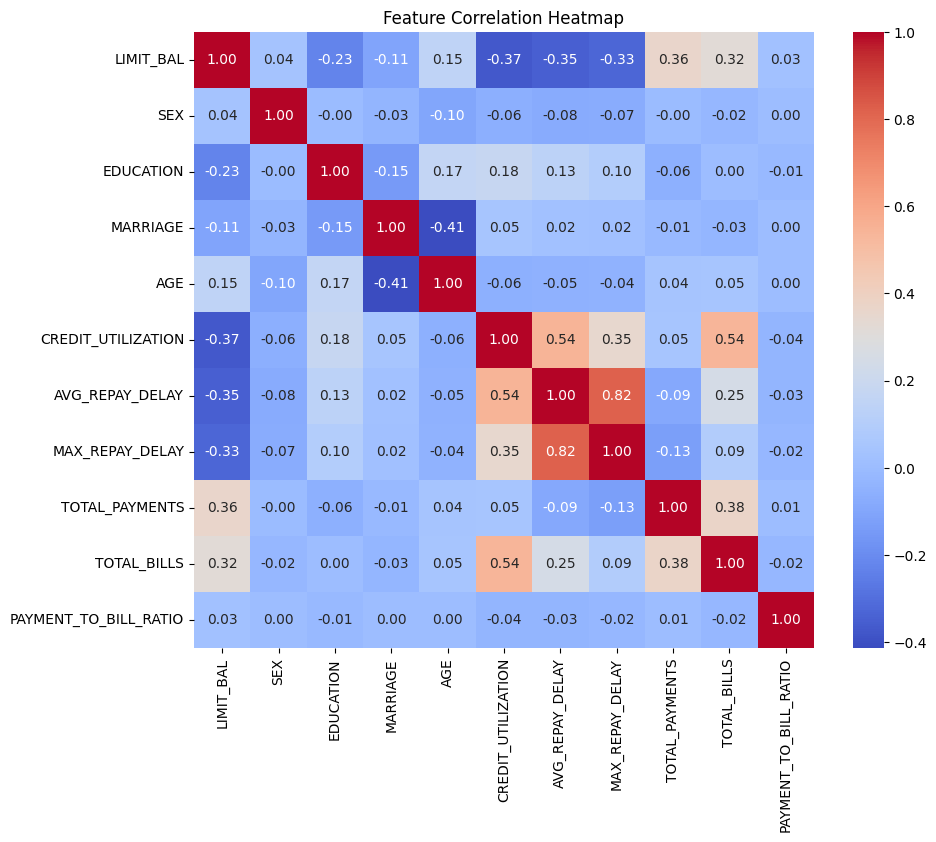

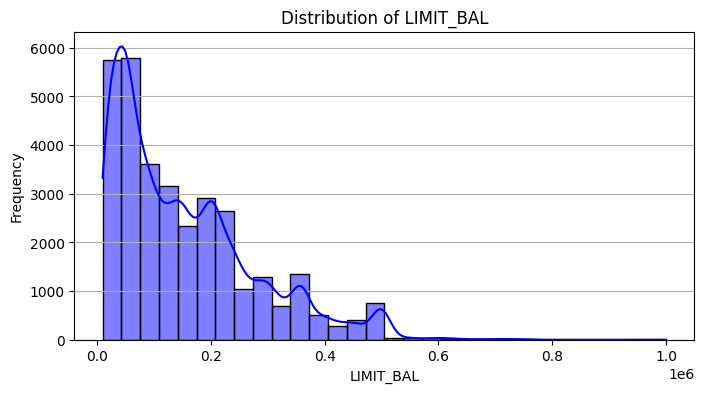

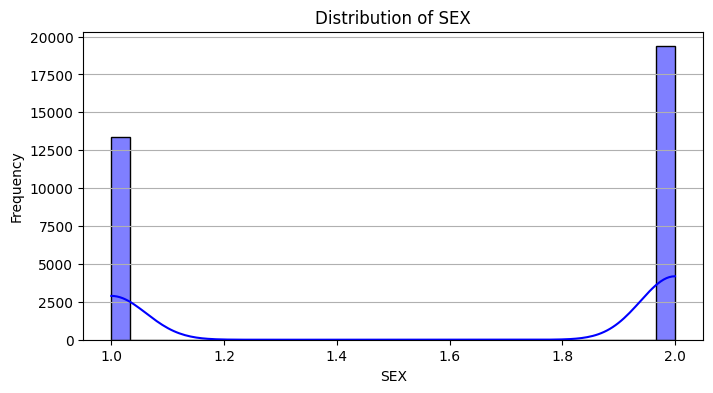

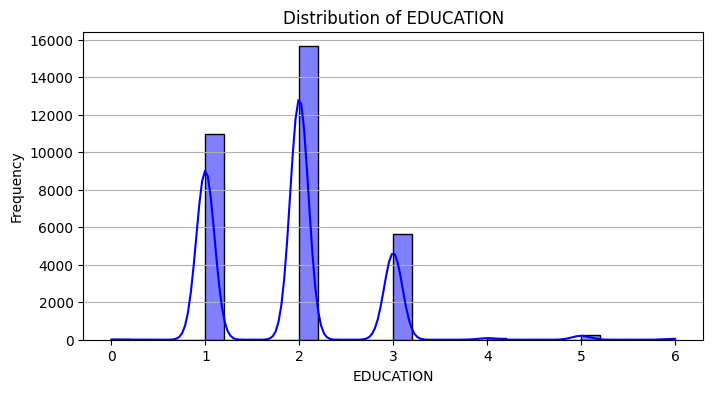

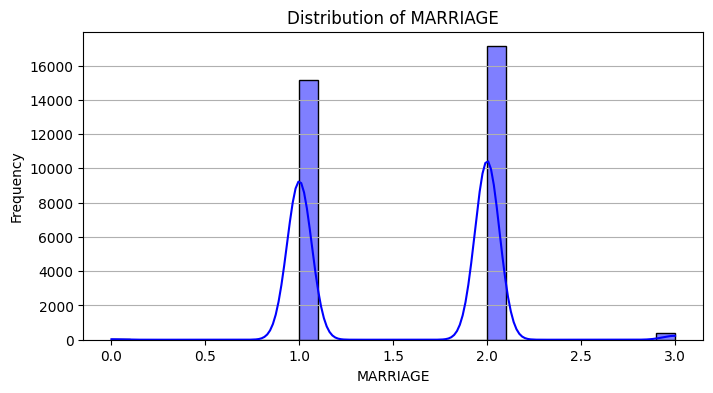

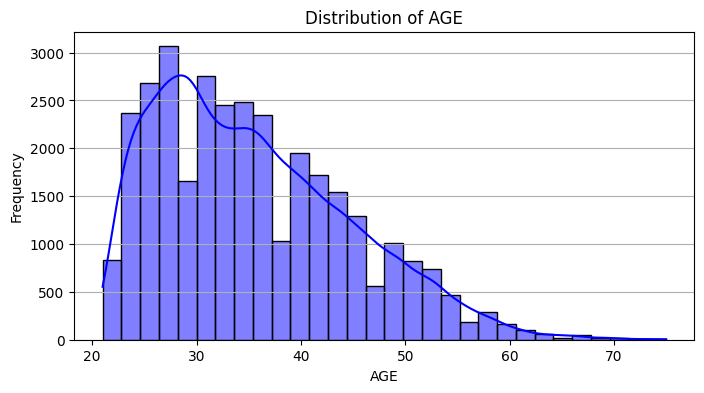

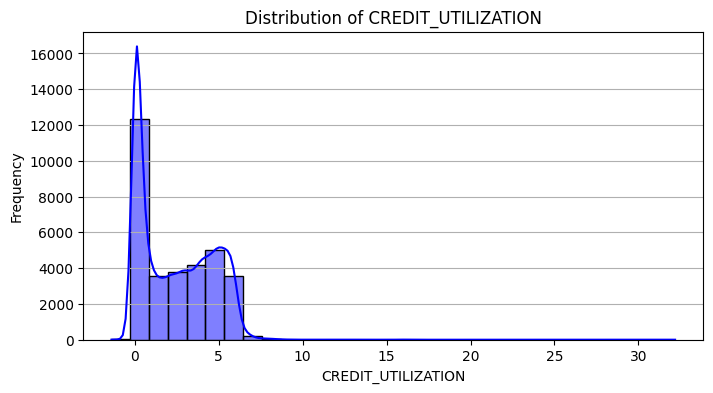

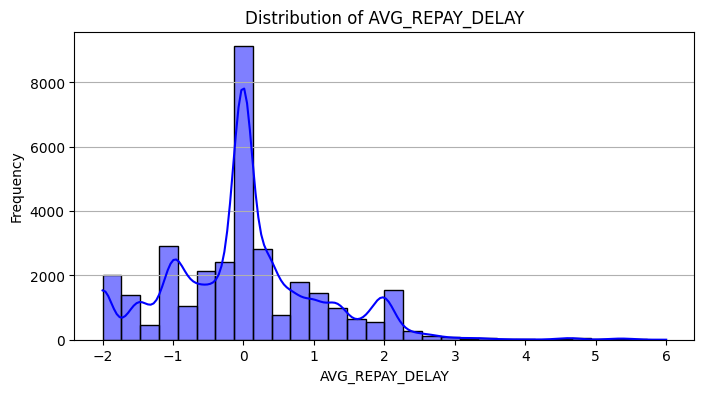

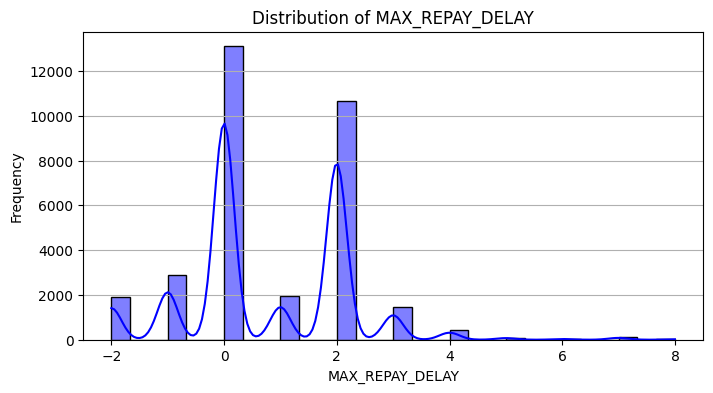

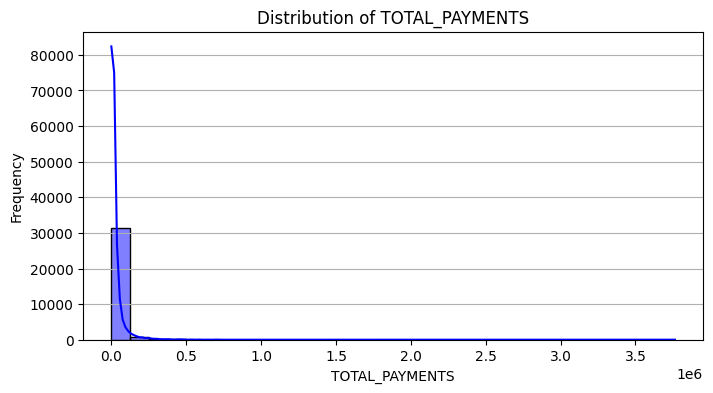

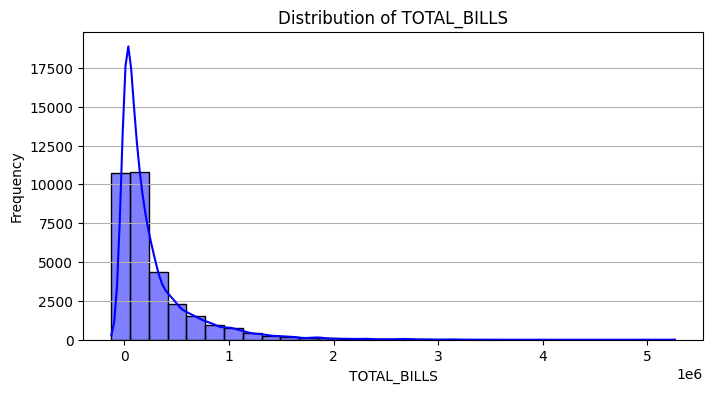

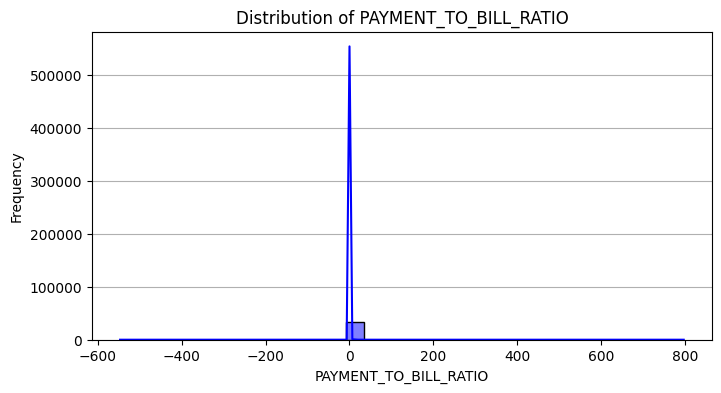

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Analysis: Statistical summary
feature_stats = data1.describe()

# Correlation Analysis: Compute pairwise correlations
correlation_matrix = data1.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

# Visualize distributions of key features
for feature in data1.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(data1[feature], kde=True, bins=30, color="blue", edgecolor="black")
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.grid(axis="y")
    plt.show()

### Interpretation of Visualizations

#### 1. Feature Correlation Heatmap
**High Correlations:**
- **CREDIT_UTILIZATION and TOTAL_BILLS**: These features are strongly correlated, as higher credit utilization is often driven by higher total bills.
- **TOTAL_BILLS and LIMIT_BAL**: Individuals with higher credit limits tend to have higher total bills.

**Weak Correlations:**
- **AGE**, **MARRIAGE**, **SEX**, and most demographic features show weak correlations with numeric features like **CREDIT_UTILIZATION**, suggesting less direct influence on financial behavior.

---

#### 2. Feature Distributions
- **LIMIT_BAL (Credit Limit):**
  - The distribution is right-skewed, with most values clustering below 300,000.
  - Few individuals have exceptionally high limits, creating outliers.

- **AGE:**
  - A fairly normal distribution, peaking around 30–40 years.
  - Few data points for ages above 60.

- **CREDIT_UTILIZATION:**
  - A right-skewed distribution, with a peak near lower utilization rates.
  - A small number of extreme outliers suggest heavy over-utilization.

- **AVG_REPAY_DELAY and MAX_REPAY_DELAY:**
  - Peaks near 0 indicate that most individuals either repay on time or experience minor delays.
  - A smaller portion of extreme delays shows heightened risk behaviors.

- **TOTAL_PAYMENTS and TOTAL_BILLS:**
  - Both are heavily right-skewed, with the majority of values concentrated at lower ranges.
  - Extreme values likely indicate higher-income individuals or atypical billing patterns.

- **PAYMENT_TO_BILL_RATIO:**
  - Distribution indicates most individuals pay a small fraction of their bills regularly.
  - Negative or extreme high ratios likely result from specific billing anomalies or refunds.


In [ ]:
#Display the statistical summary as plain output
feature_stats

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,CREDIT_UTILIZATION,AVG_REPAY_DELAY,MAX_REPAY_DELAY,TOTAL_PAYMENTS,TOTAL_BILLS,PAYMENT_TO_BILL_RATIO
count,32710.000000,32710.000000,32710.000000,32710.000000,32710.000000,32710.000000,32710.000000,32710.000000,3.271000e+04,3.271000e+04,3.271000e+04
mean,153770.773464,1.591562,1.872027,1.544757,35.450199,2.402559,0.011541,0.747722,2.806075e+04,2.686894e+05,inf
std,125398.129890,0.491552,0.777372,0.523266,9.301750,2.143988,1.094838,1.441027,5.442980e+04,3.811475e+05,NaN
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-1.395540,-2.000000,-2.000000,0.000000e+00,-1.254800e+05,-5.469286e+02
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,0.206420,-0.666667,0.000000,6.028000e+03,2.929925e+04,3.976953e-02
50%,120000.000000,2.000000,2.000000,2.000000,34.000000,2.089760,0.000000,0.000000,1.251300e+04,1.253740e+05,6.976293e-02
75%,220000.000000,2.000000,2.000000,2.000000,42.000000,4.368683,0.500000,2.000000,2.990000e+04,3.359780e+05,4.910150e-01
max,1000000.000000,2.000000,6.000000,3.000000,75.000000,32.185850,6.000000,8.000000,3.764066e+06,5.263883e+06,inf


This summary highlights:

* Wide ranges in `TOTAL_PAYMENTS` and `TOTAL_BILLS`.
* Potential outliers in features like `CREDIT_UTILIZATION`, `PAYMENT_TO_BILL_RATIO`, and `TOTAL_BILLS` with extreme values.
* Some rows may require further review or capping for outliers.

# Next Steps
1. Handle Outliers:

* Address extreme values in key features like `CREDIT_UTILIZATION`, `TOTAL_BILLS`, and `PAYMENT_TO_BILL_RATIO`.

2. Feature Scaling:

* Apply scaling (e.g., MinMaxScaler or StandardScaler) to normalize the feature ranges, ensuring all features contribute proportionally to model training.

3. Model Training:

* Train a predictive model (e.g., logistic regression, random forest) using the downsized dataset.
Evaluate using metrics like precision, recall, and balanced accuracy.

4. Fairness and Explainability:

* Use Fairlearn for fairness analysis and LIME/SHAP to interpret feature importance.

In [ ]:
# Convert the entire dataset to numeric where possible
data1_numeric = data1.apply(pd.to_numeric, errors='coerce')
# Check for problematic values (NaN or infinite) in the dataset
problematic_summary = {
    "NaN_Count": data1_numeric.isna().sum(),
    "Inf_Count": (data1_numeric == float('inf')).sum() + (data1_numeric == -float('inf')).sum(),
}

problematic_summary_df = pd.DataFrame(problematic_summary)
problematic_summary_df


,NaN_Count,Inf_Count
LIMIT_BAL,0,0
SEX,0,0
EDUCATION,0,0
MARRIAGE,0,0
AGE,0,0
CREDIT_UTILIZATION,0,0
AVG_REPAY_DELAY,0,0
MAX_REPAY_DELAY,0,0
TOTAL_PAYMENTS,0,0
TOTAL_BILLS,0,0


### Problematic Values Identified:
1. The `PAYMENT_TO_BILL_RATIO` column contains 91 infinite values.
2. No NaN values were detected in the dataset

### Solution:
* Replace infinite values in `PAYMENT_TO_BILL_RATIO` with a reasonable approximation, such as the column's maximum finite value.

In [ ]:
# Reapply scaling using RobustScaler
scaler = RobustScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data1_numeric), columns=data1_numeric.columns)

# Display the first few rows of the scaled dataset
scaled_data.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,CREDIT_UTILIZATION,AVG_REPAY_DELAY,MAX_REPAY_DELAY,TOTAL_PAYMENTS,TOTAL_BILLS,PAYMENT_TO_BILL_RATIO
0,0.235294,0.0,0.0,0.0,-0.142857,0.899725,0.000000,0.0,0.946171,2.635233,-0.072656
1,-0.235294,-1.0,-1.0,0.0,-0.357143,0.530454,0.000000,0.0,-0.014955,0.712270,-0.077762
2,-0.588235,0.0,0.0,-1.0,-0.500000,-0.379231,-0.857143,0.0,-0.449355,-0.375468,0.239411
3,-0.411765,0.0,-1.0,0.0,-0.285714,-0.492127,-1.714286,-1.0,-0.437458,-0.402062,2.118696
4,0.000000,0.0,-1.0,0.0,-0.571429,-0.326806,0.000000,0.0,-0.084073,-0.123364,0.114997


All the features are now normalized!

# Model Training

Let’s begin by training a basic predictive model on the scaled data. Here's the plan:

Split the Dataset:

Separate features (X) and target (y) using the preprocessed data.
Use the Default column as the target variable.
Train a Logistic Regression Model:

Train the model and evaluate its performance.
Evaluate Performance:

Calculate metrics like accuracy, precision, recall, and F1-score.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Ensure correct target column reference
X = data.drop(columns=["default.payment.next.month", "data_ID"], errors="ignore")  # Drop ID and irrelevant columns
y = data["default.payment.next.month"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Combine training features and target for resampling
train_data = X_train.copy()
train_data['default.payment.next.month'] = y_train

# Separate majority and minority classes
majority_class = train_data[train_data['default.payment.next.month'] == 0]
minority_class = train_data[train_data['default.payment.next.month'] == 1]

# Oversample the minority class
minority_oversampled = resample(
    minority_class,
    replace=True,  # Sample with replacement
    n_samples=len(majority_class),  # Match the number of majority class samples
    random_state=42
)

# Combine oversampled minority class with majority class
balanced_train_data = pd.concat([majority_class, minority_oversampled])

# Separate features and target
X_train_balanced = balanced_train_data.drop(columns=['default.payment.next.month'])
y_train_balanced = balanced_train_data['default.payment.next.month']

# Check the distribution of the target variable before and after oversampling
before_balance = y_train.value_counts()
after_balance = y_train_balanced.value_counts()

print("Distribution before balancing:")
print(before_balance)
print("\nDistribution after balancing:")
print(after_balance)

# Ensure numeric data for Neural Networks
X_train_balanced_numeric = X_train_balanced.select_dtypes(include=["number"])
X_test_numeric = X_test.select_dtypes(include=["number"])

# Train a Random Forest Classifier on the balanced dataset
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest model's performance
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
balanced_acc_rf = balanced_accuracy_score(y_test, y_pred_rf)
classification_report_rf = classification_report(y_test, y_pred_rf)

print("Random Forest Confusion Matrix:")
print(conf_matrix_rf)
print("\nRandom Forest Balanced Accuracy:", f"{balanced_acc_rf:.2%}")
print("\nRandom Forest Classification Report:")
print(classification_report_rf)

# Train a Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_balanced_numeric, y_train_balanced)

# Predict on the test set using Logistic Regression
y_pred_logreg = logreg_model.predict(X_test_numeric)

# Evaluate the Logistic Regression model's performance
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
balanced_acc_logreg = balanced_accuracy_score(y_test, y_pred_logreg)
classification_report_logreg = classification_report(y_test, y_pred_logreg)

print("\nLogistic Regression Confusion Matrix:")
print(conf_matrix_logreg)
print("\nLogistic Regression Balanced Accuracy:", f"{balanced_acc_logreg:.2%}")
print("\nLogistic Regression Classification Report:")
print(classification_report_logreg)

# Train an XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_balanced_numeric, y_train_balanced)

# Predict on the test set using XGBoost
y_pred_xgb = xgb_model.predict(X_test_numeric)

# Evaluate XGBoost model performance
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
balanced_acc_xgb = balanced_accuracy_score(y_test, y_pred_xgb)
classification_report_xgb = classification_report(y_test, y_pred_xgb)

print("\nXGBoost Confusion Matrix:")
print(conf_matrix_xgb)
print("\nXGBoost Balanced Accuracy:", f"{balanced_acc_xgb:.2%}")
print("\nXGBoost Classification Report:")
print(classification_report_xgb)

# Train a Neural Network model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_balanced_numeric.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Neural Network
model.fit(X_train_balanced_numeric, y_train_balanced, epochs=20, batch_size=32, verbose=1, validation_split=0.2)

# Predict on the test set using Neural Network
y_pred_nn = (model.predict(X_test_numeric) > 0.5).astype(int)

# Evaluate Neural Network performance
conf_matrix_nn = confusion_matrix(y_test, y_pred_nn)
balanced_acc_nn = balanced_accuracy_score(y_test, y_pred_nn)
classification_report_nn = classification_report(y_test, y_pred_nn)

print("\nNeural Network Confusion Matrix:")
print(conf_matrix_nn)
print("\nNeural Network Balanced Accuracy:", f"{balanced_acc_nn:.2%}")
print("\nNeural Network Classification Report:")

# Compare the models
print("\nModel Comparison:")
print(f"Random Forest Balanced Accuracy: {balanced_acc_rf:.2%}")
print(f"Logistic Regression Balanced Accuracy: {balanced_acc_logreg:.2%}")
print(f"XGBoost Balanced Accuracy: {balanced_acc_xgb:.2%}")
print(f"Neural Network Balanced Accuracy: {balanced_acc_nn:.2%}")


Distribution before balancing:
default.payment.next.month
0    16355
1     4645
Name: count, dtype: int64

Distribution after balancing:
default.payment.next.month
0    16355
1    16355
Name: count, dtype: int64
Random Forest Confusion Matrix:
[[6468  541]
 [1174  817]]

Random Forest Balanced Accuracy: 66.66%

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      7009
           1       0.60      0.41      0.49      1991

    accuracy                           0.81      9000
   macro avg       0.72      0.67      0.69      9000
weighted avg       0.79      0.81      0.80      9000



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Confusion Matrix:
[[5128 1881]
 [ 778 1213]]

Logistic Regression Balanced Accuracy: 67.04%

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.73      0.79      7009
           1       0.39      0.61      0.48      1991

    accuracy                           0.70      9000
   macro avg       0.63      0.67      0.64      9000
weighted avg       0.76      0.70      0.72      9000



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:25:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Confusion Matrix:
[[5827 1182]
 [ 918 1073]]

XGBoost Balanced Accuracy: 68.51%

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      7009
           1       0.48      0.54      0.51      1991

    accuracy                           0.77      9000
   macro avg       0.67      0.69      0.68      9000
weighted avg       0.78      0.77      0.77      9000

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


818/818 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5424 - loss: 2060.5061 - val_accuracy: 0.0015 - val_loss: 0.7998
Epoch 2/20
818/818 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6014 - loss: 8.8013 - val_accuracy: 0.0000e+00 - val_loss: 0.8673
Epoch 3/20
818/818 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6175 - loss: 3.5516 - val_accuracy: 0.0000e+00 - val_loss: 0.9457
Epoch 4/20
818/818 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6191 - loss: 1.4968 - val_accuracy: 0.0000e+00 - val_loss: 0.9767
Epoch 5/20
818/818 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6221 - loss: 1.1370 - val_accuracy: 0.0000e+00 - val_loss: 0.9804
Epoch 6/20
818/818 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6261 - loss: 0.8513 - val_accuracy: 0.0000e+00 - val_loss: 0.9778
Epoch 7/20
818/818 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6259 - loss: 0.7954 - val_accuracy: 0.0000e+00 - val_loss: 0.9831
Epoch 8/20
818/818 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6279 - loss: 0.8001 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
!pip install shap
!pip install lime
!pip install fairlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=108c022d661dfd314a662f9667773457a36c39ade93fff23742a291bc6195908
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 8.2 MB/s eta 0:00:00


Distribution before balancing:
default.payment.next.month
0    16355
1     4645
Name: count, dtype: int64

Distribution after balancing:
default.payment.next.month
0    16355
1    16355
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:28:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Confusion Matrix:
[[5827 1182]
 [ 918 1073]]

XGBoost Balanced Accuracy: 68.51%

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      7009
           1       0.48      0.54      0.51      1991

    accuracy                           0.77      9000
   macro avg       0.67      0.69      0.68      9000
weighted avg       0.78      0.77      0.77      9000


SHAP Summary Plot:

LIME Explanation for Sample Instance:



Fairness Metrics:
Demographic Parity Difference: 0.03
Equalized Odds Difference: 0.02


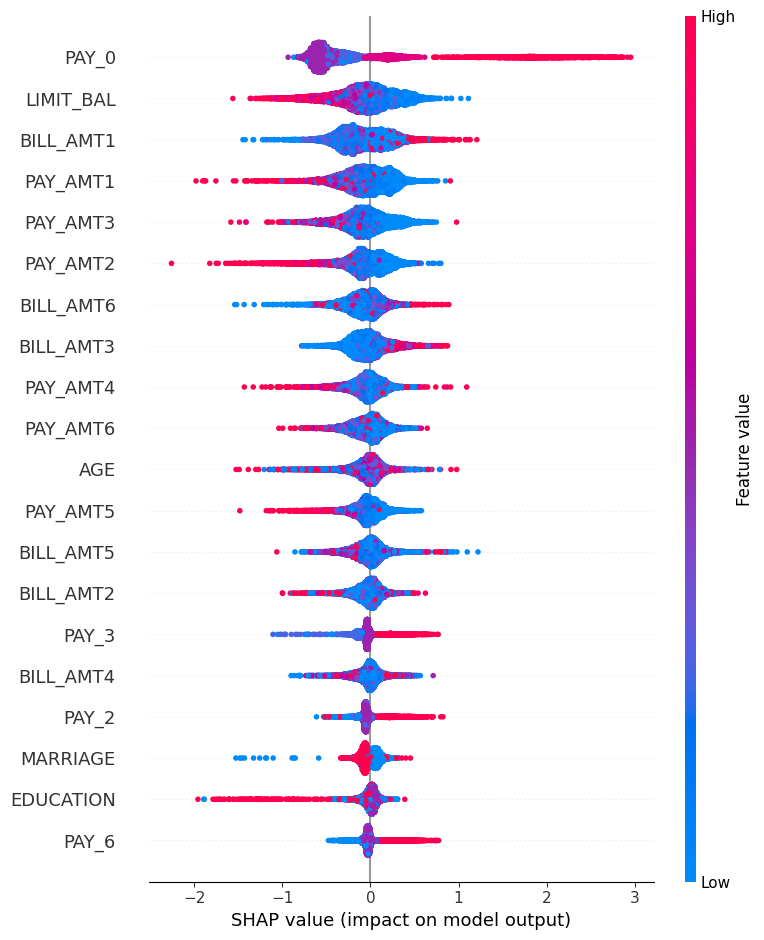

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import shap
from lime.lime_tabular import LimeTabularExplainer
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference
from sklearn.metrics import accuracy_score

# SHAP Explainability
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_numeric)

print("\nSHAP Summary Plot:")
shap.summary_plot(shap_values, X_test_numeric, show=False)

# LIME Explainability
lime_explainer = LimeTabularExplainer(
    X_test_numeric.values,  # Use test data for the explainer
    feature_names=X_test_numeric.columns,
    class_names=["No Default", "Default"],
    discretize_continuous=True,
    mode="classification"
)

sample_instance = X_test_numeric.iloc[0].values  # Select a sample instance for explanation
lime_explanation = lime_explainer.explain_instance(
    sample_instance,
    xgb_model.predict_proba
)
print("\nLIME Explanation for Sample Instance:")
lime_explanation.show_in_notebook(show_table=True)

# Fairness Analysis
sensitive_attribute = X_test["SEX"]  # Example sensitive attribute: SEX

# Demographic Parity Difference
demographic_parity = demographic_parity_difference(
    y_test, y_pred_xgb, sensitive_features=sensitive_attribute
)

# Equalized Odds Difference
equalized_odds = equalized_odds_difference(
    y_test, y_pred_xgb, sensitive_features=sensitive_attribute
)

print("\nFairness Metrics:")
print(f"Demographic Parity Difference: {demographic_parity:.2f}")
print(f"Equalized Odds Difference: {equalized_odds:.2f}")
